In [ ]:
!rm -rf ventmap waveforms labels *.csv
!unzip ventmap.zip 
!unzip waveforms.zip 
!unzip labels.zip 

Archive:  ventmap.zip
   creating: ventmap/
  inflating: ventmap/add_timestamp_to_file.py  
  inflating: ventmap/anonymize_datatimes.py  
  inflating: ventmap/breath_meta.py  
  inflating: ventmap/clear_null_bytes.py  
  inflating: ventmap/constants.py    
  inflating: ventmap/convert_3_col_file_to_2_col.py  
  inflating: ventmap/cut_breath_section.py  
  inflating: ventmap/detection.py    
  inflating: ventmap/preprocess_all_files.py  
  inflating: ventmap/raw_utils.py    
  inflating: ventmap/rounding_rules.py  
  inflating: ventmap/SAM.py          
 extracting: ventmap/__init__.py     
Archive:  waveforms.zip
   creating: waveforms/
   creating: waveforms/1/
   creating: waveforms/10/
  inflating: waveforms/10/1008cut.csv  
   creating: waveforms/11/
  inflating: waveforms/11/1009cut.csv  
   creating: waveforms/12/
  inflating: waveforms/12/1010_1cut.csv  
   creating: waveforms/13/
  inflating: waveforms/13/1010_2cut.csv  
   creating: waveforms/14/
  inflating: waveforms/14/1011c

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, concatenate, GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, TimeDistributed, ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from ventmap.raw_utils import extract_raw


In [ ]:
def load_waveform_data():
    """load flow & pressure waveforms into list respectively"""
    flows = []
    pressures = []
    flow_list = []
    pressure_list = []

    for (dir_path, dir_names, file_names) in os.walk('./waveforms'):
        for file in file_names:
            csv_path = os.path.join(dir_path, file)
            # print("waveforms path: " + csv_path)
            generator = extract_raw(open(csv_path), False)
            for breath in generator:
                # breath data is output in dictionary format
                flow, pressure = breath['flow'], breath['pressure']
                flows += flow
                pressures += pressure
                flow_list.append(flow)
                pressure_list.append(pressure)

    return flow_list, pressure_list

In [ ]:
def load_label_data():
    """load the label data corresponding to waveforms"""
    labels = []
    for (dir_path, dir_names, file_names) in os.walk('./labels'):
        for file in file_names:
            csv_path = os.path.join(dir_path, file)
            # print("label path: " + csv_path)
            df = pd.read_csv(csv_path)
            df_filter = df[['dbl', 'mt', 'bs', 'co', 'su']]
            labels.append(df_filter)
    df_total = pd.concat(labels, axis=0, ignore_index=True)
    label_arr = df_total.to_numpy()

    # check if the pva type is unique in each row
    test = (df_total == 0).sum(axis=1) < 4
    count = 0
    for index, value in test.items():
        if value:
            count += 1
    print("pva type not unique amount:" + str(count))

    return label_arr

In [ ]:
def waveform_trim(pressure_list):
    """unify the length of wall the waveform sections"""
    len_list = []
    for pressure in pressure_list:
        len_list.append(len(pressure))
    len_trim = int(np.percentile(len_list, 90))

    return len_trim

In [ ]:
def check_notation(notation, i):
    """specify the labels based on the raw notation data"""
    if notation[i][0] == 1:
        label = 1 #"dbl"
    elif notation[i][1] == 1:
        label = 2 #"mt"
    elif notation[i][2] == 1:
        label = 3 #"bs"
    elif notation[i][3] == 1:
        label = 4 #"co"
    elif notation[i][4] == 1:
        label = 5 #"su"
    else:
        label = 0 #"normal"

    return label

In [ ]:
def plot_sample_data(flows, pressures):
    """plot the sample waveform data of flow & pressure"""
    plt.figure(figsize=(20, 5))
    plt.plot(flows[:2000], label='Flow')
    plt.plot(pressures[:2000], label='Pressure')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

In [ ]:
def load_train_test_data():
    """generate train and test data based on the waveforms & labels"""
    waveform_f = []
    waveform_p = []
    labels = []
    loaded = list()

    flow_list, pressure_list = load_waveform_data()
    label_arr = load_label_data()
    len_trim = waveform_trim(pressure_list)

    for i in range(len(pressure_list)):
        flow = flow_list[i]
        pressure = pressure_list[i]

        if len(pressure) < len_trim:
            pressure_ext = np.concatenate([pressure, np.zeros(len_trim-len(pressure))])
            pressure_ext = pressure_ext.tolist()
            flow_ext = np.concatenate([flow, np.zeros(len_trim-len(flow))])
            flow_ext = flow_ext.tolist()
            waveform_p.append(pressure_ext)
            waveform_f.append(flow_ext)
            label = check_notation(label_arr, i)
            labels.append(label)
        else:
            pressure_ext = pressure[:len_trim]
            flow_ext = flow[:len_trim]
            waveform_p.append(pressure_ext)
            waveform_f.append(flow_ext)
            label = check_notation(label_arr, i)
            labels.append(label)

    df_p = pd.DataFrame(waveform_p)
    df_f = pd.DataFrame(waveform_f)
    df_l = pd.DataFrame(labels)
    loaded.append(df_p)
    loaded.append(df_f)
    
    waveforms = np.dstack(loaded)
    notations = df_l.values
    trainX, testX, trainy, testy = train_test_split(waveforms, notations, test_size=0.3)
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, testX.shape, trainy.shape, testy.shape)

    return trainX, testX, trainy, testy 

In [ ]:
def evaluate_model(trainX, trainy, testX, testy):
    """fit and evaluate a model"""
    verbose, epochs, batch_size = 1, 30, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    print(n_timesteps, n_features, n_outputs)

    #LSTM
    # model = Sequential()
    # model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    # model.add(Dropout(0.5))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(n_outputs, activation='softmax'))
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.summary()

    #CNN-LSTM
    # n_steps, n_length = 5, 43
    # trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    # testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # model = Sequential()
    # model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    # model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    # model.add(TimeDistributed(Dropout(0.5)))
    # model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # model.add(TimeDistributed(Flatten()))
    # model.add(LSTM(100))
    # model.add(Dropout(0.5))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(n_outputs, activation='softmax'))
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # ConvLSTM 
    # n_steps, n_length = 5, 43
    # trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    # testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    # model = Sequential()
    # model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    # model.add(Dropout(0.5))
    # model.add(Flatten())
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(n_outputs, activation='softmax'))
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

trainX, testX, trainy, testy = load_train_test_data()
print("train and test data ready!")
# evaluate_model(trainX, trainy, testX, testy)

pva type not unique amount:9
(6803, 215, 2) (2916, 215, 2) (6803, 6) (2916, 6)
train and test data ready!


In [ ]:
def plot_train_history(history, title):
    """plot training result"""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.grid(True)
    plt.title(title)
    plt.legend()
    plt.show()

pva type not unique amount:9
(6803, 215, 2) (2916, 215, 2) (6803, 6) (2916, 6)
train and test data ready!
215 2 6
Epoch 1/50
96/96 - 1s - loss: 0.8635 - accuracy: 0.6975 - val_loss: 0.6751 - val_accuracy: 0.7827
Epoch 2/50
96/96 - 1s - loss: 0.6813 - accuracy: 0.7713 - val_loss: 0.5809 - val_accuracy: 0.7974
Epoch 3/50
96/96 - 1s - loss: 0.5977 - accuracy: 0.7828 - val_loss: 0.5827 - val_accuracy: 0.7959
Epoch 4/50
96/96 - 1s - loss: 0.5539 - accuracy: 0.8030 - val_loss: 0.5415 - val_accuracy: 0.8003
Epoch 5/50
96/96 - 1s - loss: 0.5056 - accuracy: 0.8135 - val_loss: 0.5018 - val_accuracy: 0.8135
Epoch 6/50
96/96 - 1s - loss: 0.4770 - accuracy: 0.8262 - val_loss: 0.4729 - val_accuracy: 0.8355
Epoch 7/50
96/96 - 1s - loss: 0.4532 - accuracy: 0.8352 - val_loss: 0.5153 - val_accuracy: 0.8223
Epoch 8/50
96/96 - 1s - loss: 0.4403 - accuracy: 0.8340 - val_loss: 0.4475 - val_accuracy: 0.8458
Epoch 9/50
96/96 - 1s - loss: 0.4187 - accuracy: 0.8437 - val_loss: 0.4618 - val_accuracy: 0.8370
Epoc

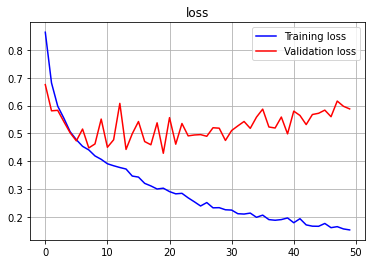

In [ ]:
trainX, testX, trainy, testy = load_train_test_data()
print("train and test data ready!")

# Select a model you prefer to use
verbose, epochs, batch_size = 2, 50, 64
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
print(n_timesteps, n_features, n_outputs)
# #LSTM
# model = Sequential()
# model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
# model.add(Dropout(0.5))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(n_outputs, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

# CNN-LSTM
n_steps, n_length = 5, 43
trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # ConvLSTM
# n_steps, n_length = 5, 43
# trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
# testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
# model = Sequential()
# model.add(ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(n_outputs, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

multi_step_history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1)

pred_test = model.predict(testX)
print("the first predict: {}".format(np.shape(pred_test)))
print(pred_test[0])
pred_test = np.argmax(pred_test, axis=-1)
print("the second predict: {}".format(np.shape(pred_test)))

testy = np.argmax(testy, axis=-1)
print("testy shape:{}".format(np.shape(testy)))
# f1 = f1_score(testy, pred_test, average="mac+ro")
# print("Test f1 score : %s "% f1)
acc = accuracy_score(testy, pred_test)
print("Test accuracy score : %s "% acc)
plot_train_history(multi_step_history, "loss")